documentation on solve_ivp

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [1]:
#from specializer import DirectedGraph
#from specializeGraph import *
import numpy as np
from sklearn.linear_model import Ridge
from scipy import integrate
import matplotlib.pyplot as plt

In [242]:
def lorentz_deriv(t0, X, sigma=10., beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorenz system."""
    (x, y, z) = X
    #print(t0)
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

x0 = [.5, 0, -.5]  # starting vector
t = np.linspace(0, 3, 80000)  # two thousand time steps
lorenz_bunch = integrate.solve_ivp(lorentz_deriv, (0,3), x0, dense_output=True)
x_t = lorenz_bunch.y
lorenz_sol = lorenz_bunch.sol # this is now a callable function of t that is an approximate solution to lorenz
t1 = t[:len(t)//2]
t2 = t[len(t)//2:]

In [278]:
class ResComp:
    def __init__(self, num_in, num_out, res_sz=200, activ_f=np.tanh, connect_p=.1, ridge_alpha=.00001,spect_rad=.9, gamma = 1.,sigma = 0.12
                ):
        
        # Set model attributes
        self.W_in        = np.random.rand(res_sz, num_in) - .5
        self.W_out       = np.zeros((num_out, res_sz))
        self.gamma       = sigma
        self.sigma       = gamma
        self.activ_f     = activ_f
        self.ridge_alpha = ridge_alpha
        self.state_0     = np.random.rand(res_sz)
        
        # Make reservoir
        self.res   = np.random.rand(res_sz, res_sz) - .5
        self.res[np.random.rand(res_sz,res_sz) > connect_p] = 0
        self.res *= spect_rad/max(np.linalg.eigvals(self.res)).real
        
    # end
    
    def drive(self,t,u):
        """
        Parameters
        t (1 dim ndarray): an array of time values
        u (function)     : for each i, u(t[i]) produces the state of the system that is being learned
        """
        
        # Reservoir ode
        def res_f(r,t):
            return self.gamma*(-1*r + self.activ_f( self.res.dot(r) + self.sigma*self.W_in.dot(lorenz_sol(t))))
        #end
        
        r_0    = self.state_0
        states = integrate.odeint(res_f,r_0,t)
        self.state_0 = states[-1]
        return states
    # end
    
    
    def fit(self, t, u):
        """
        Parameters
        t (1 dim ndarray): an array of time values
        u (function)     : for each i, u(t[i]) produces the state of the system that is being learned
        """
        
        driven_states    = self.drive(t,u)
        true_states      = lorenz_sol(t).T
        ridge_regression = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        ridge_regression.fit(driven_states,true_states)
        self.W_out       = ridge_regression.coef_
        
    # end
    
 
    def predict(self, t, r_0=None):
        # Reservoir prediction ode
        
        def res_pred_f(r,t):
            return self.gamma*(-1*r + self.activ_f( self.res.dot(r) + self.sigma*self.W_in.dot(self.W_out.dot(r))))
        # end
        
        if r_0 is None:
            r_0  = self.state_0
        # end
        
        pred = integrate.odeint(res_pred_f, r_0, t)
        return self.W_out.dot(pred.T)
    # end
    

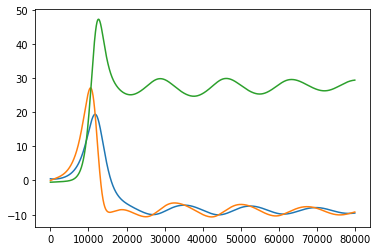

In [343]:
m = ResComp(3,3, res_sz=400)
x0 = [.5, 0, -.5]  # starting vector
t = np.linspace(0, 3, 80000)  # two thousand time steps
lorenz_bunch = integrate.solve_ivp(lorentz_deriv, (0,3), x0, dense_output=True)
lorenz_sol = lorenz_bunch.sol # this is now a callable function of t that is an approximate solution to lorenz
t1 = t[:len(t)//2]
t2 = t[len(t)//2:]
r_0 = m.state_0
m.fit(t1, lorenz_sol)
pre = m.predict(t,r_0=r_0)
plt.plot(pre.T)
plt.show()

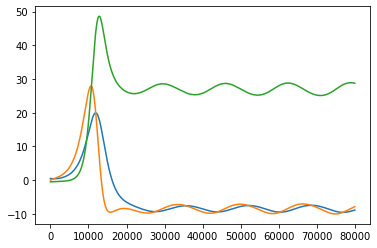

In [342]:
plt.plot(lorenz_sol(t).T)
plt.show()

In [ ]:
def avg_predict_err(res_sz):
    m = ResComp(3,3, res_sz=400)
    r_0 = m.state_0
    m.fit(t1)
    pre = m.predict(t,r_0=r_0)

Ignore the below code

In [182]:
len(m.intercept_)

3

In [183]:
m.coef_

array([[ 9.85037359e-01,  1.49229915e-02, -9.93037297e-05],
       [-8.86127368e-03,  1.00352441e+00, -1.33286716e-02],
       [-9.96696058e-03,  2.17819006e-02,  1.00024712e+00]])

In [179]:
x_t

array([[10.        ,  5.        , -5.        ],
       [ 9.92915002,  5.48486488, -4.90178992],
       [ 9.86653594,  5.96420194, -4.79734949],
       ...,
       [-9.16501416, -6.70535662, 30.67780398],
       [-9.12802791, -6.6587828 , 30.6468151 ],
       [-9.09090368, -6.61285612, 30.61494808]])

In [199]:
pre1 = np.apply_along_axis(lambda x : x + m.intercept_, 0, m.coef_.dot(x_t[:-1,:].T))

In [205]:
pre2 = m.coef_.dot(x_t[:-1,:].T)
y = x_t[1:,:].T
np.linalg.norm(pre1 - y, ord=2)

3.921026336668609

In [77]:
len(t)//2

1000

In [319]:
import networkx as nx
FNAME      = "/Users/djpassey/Code/work/NetworkResearch/UVMproject/data/specRandNets/specNetw{}.csv"


In [320]:
spec      = np.genfromtxt(FNAME.format(i), delimiter=",")

In [322]:
G = nx.DiGraph(spec)

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)